DIVA

In [1]:
%matplotlib inline
import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
from SensorimotorExploration.DataManager.SimulationData import load_sim_h5
from SensorimotorExploration.DataManager.PlotTools import *

In [3]:
def create_dict(groups_k):
    return {k[0] + '_' + k[1]: [] for k in groups_k}


def incremental_mean(arr_):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(n_samples):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    out = np.array(out).flatten()
    return out

def moving_av(arr_, win_sz):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(win_sz):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    for i in range(win_sz,n_samples):
        sum_ = sum_ + arr_[i] - arr_[i-win_sz]
        out += [sum_/win_sz]
    out = np.array(out).flatten()
    return out

def std_markers(ax,y,m,c,sz):
    plt.sca(ax)
    plt.hold(True)
    for i,(y_,ms_) in enumerate(zip(y,sz)):
        plt.plot(i, y_, marker = m, ms = ms_, color = c)

In [4]:
directory = 'experiment_2_cb_ins05/'
data_files = os.listdir(directory)

# Group by:
type_ops = ['proprio', 'simple']
mode_ops = ['autonomous', 'social']

groups_k = list(itertools.product(type_ops, mode_ops))

means_s = create_dict(groups_k)
means_av_s = create_dict(groups_k)

means_w = create_dict(groups_k)
means_av_w = create_dict(groups_k)

coll_s = create_dict(groups_k)
coll_av_s = create_dict(groups_k)

coll_w = create_dict(groups_k)
coll_av_w = create_dict(groups_k)

inter = create_dict(groups_k)
inter_av = create_dict(groups_k)

error_ev = create_dict(groups_k)
error_ev_av = create_dict(groups_k)

std_ev = create_dict(groups_k)

comp_w = create_dict(groups_k)
comp_av_w = create_dict(groups_k)

for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
    data_file = directory + data_file
    conf_file = data_file.replace('sim_data.h5', 'conf.txt')
    conf = {}
    with open(conf_file) as f:
        for line in f:
            line = line.replace('\n', '')
            (key, val) = line.split(': ')
            conf[key] = val

    try:
        whole_data = load_sim_h5(data_file)
        interaction_data = whole_data.social.data.as_matrix(columns=None)
        interactions = np.zeros((interaction_data.shape[0],))
        interactions[~np.isnan(interaction_data[:, 0])] = 1
#         print(np.sum(interactions))


        social_data = load_sim_h5(data_file.replace('sim_data.h5', 'eva_valset.h5'))

        s_error_ = np.linalg.norm(social_data.sensor_goal.data.as_matrix() -
                                  social_data.sensor.data.as_matrix(), axis=1)


        s_con_v = social_data.somato.data.as_matrix()

        w_error_ = np.linalg.norm(whole_data.sensor_goal.data.as_matrix() -
                                  whole_data.sensor.data.as_matrix(), axis=1)

        w_con_v = whole_data.somato.data.as_matrix()
        
        w_comp_w = whole_data.competence.data.as_matrix()

        eva_errors = []
        with open(data_file.replace('sim_data.h5', 'eval_error.txt'), 'r') as f:
            for line in f:
                line.replace('\n','')
                eva_errors_str = line.split(': ')
                eva_errors += [float(eva_errors_str[1])]

        means_s[conf['type'] + '_' + conf['mode']] += [np.mean(s_error_)]
        means_w[conf['type'] + '_' + conf['mode']] += [np.mean(w_error_)]

        coll_s[conf['type'] + '_' + conf['mode']] += [s_con_v[:250200]]
        coll_w[conf['type'] + '_' + conf['mode']] += [w_con_v[:250200]]

        inter[conf['type'] + '_' + conf['mode']] += [interactions[:250200]]

        error_ev[conf['type'] + '_' + conf['mode']] += [eva_errors]
        
        comp_w[conf['type'] + '_' + conf['mode']] += [w_error_[:250200]]
        
#         print(conf['type'] + '_' + conf['mode'])
#         print(np.sum(interactions))
    except IOError:
        pass

max_std=0
for i, k in enumerate(groups_k):
    group = k[0] + '_' + k[1]

    means_av_s[group] = np.mean(np.array(means_s[group]))
    means_av_w[group] = np.mean(np.array(means_w[group]))

    coll_av_s[group] = np.mean(np.array(coll_s[group]), axis=0)
    coll_av_w[group] = np.mean(np.array(coll_w[group]), axis=0)

    inter_av[group] = np.mean(np.array(inter[group]), axis=0)

    comp_av_w[group] = np.mean(np.array(comp_w[group]), axis=0)
    
    error_ev_av[group]= np.mean(np.array(error_ev[group]),axis=0)
    std_ev[group] = np.std(np.array(error_ev[group]),axis=0)
    max_std = max(max_std,max(std_ev[group].flatten()))
print(max_std)

0.323208946506


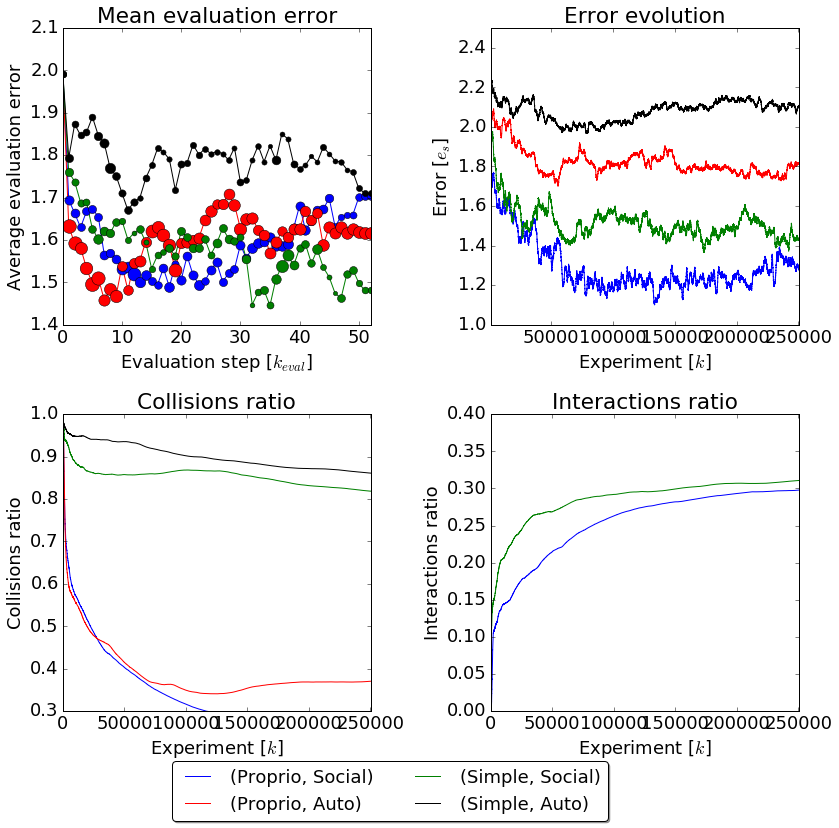

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 11.0)
matplotlib.rcParams.update({'font.size': 18})


fig1, ax1 = plt.subplots(2,2)
plt.sca(ax1[0,0])
ax1[0,0].set_title('Mean evaluation error')
plt.hold(True)
plt.plot(error_ev_av['proprio_social'], linestyle='-', marker='', color='b')
ms1 = [(x/max_std)*13 + 1 for x in std_ev['proprio_social']]

plt.plot(error_ev_av['proprio_autonomous'], linestyle='-', marker='', color='r')
ms2 = [(x/max_std)*13 + 1 for x in std_ev['proprio_autonomous']]

plt.plot(error_ev_av['simple_social'], linestyle='-', marker='', color='g')
ms3 = [(x/max_std)*13 + 1 for x in std_ev['simple_social']]

plt.plot(error_ev_av['simple_autonomous'], linestyle='-', marker='', color='k')
ms4 = [(x/max_std)*13 + 1 for x in std_ev['simple_autonomous']]

std_markers(ax1[0,0],error_ev_av['proprio_social'],'o','b',ms1)
std_markers(ax1[0,0],error_ev_av['proprio_autonomous'],'o','r',ms2)
std_markers(ax1[0,0],error_ev_av['simple_social'],'o','g',ms3)
std_markers(ax1[0,0],error_ev_av['simple_autonomous'],'o','k',ms4)

plt.xlabel('Evaluation step [$k_{eval}$]')
plt.ylabel('Average evaluation error')
# plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'],\
#            ncol=2,loc='lower right', fontsize=13)
ax1[0,0].set_xlim([0,52])
ax1[0,0].set_ylim([1.4,2.1])

plt.sca(ax1[0,1])
ax1[0,1].set_title('Error evolution')
plt.plot(moving_av(comp_av_w['proprio_social'],1000), linestyle='-', marker='', color='b')
plt.hold(True)
plt.plot(moving_av(comp_av_w['proprio_autonomous'],1000), linestyle='-', marker='', color='r')
plt.plot(moving_av(comp_av_w['simple_social'],1000), linestyle='-', marker='', color='g')
plt.plot(moving_av(comp_av_w['simple_autonomous'],1000), linestyle='-', marker='', color='k')
plt.xlabel('Experiment [$k$]')
plt.ylabel('Error [$e_s$]')
# plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'],\
#            ncol=2,loc='lower right', fontsize=13)
ax1[0,1].set_xlim([1000,250200])
ax1[0,1].set_ylim([1,2.5])


plt.sca(ax1[1,0])
ax1[1,0].set_title('Collisions ratio')
plt.plot(incremental_mean(coll_av_w['proprio_social']), linestyle='-', marker='', color='b')
plt.hold(True)
plt.plot(incremental_mean(coll_av_w['proprio_autonomous']), linestyle='-', marker='', color='r')
plt.plot(incremental_mean(coll_av_w['simple_social']), linestyle='-', marker='', color='g')
plt.plot(incremental_mean(coll_av_w['simple_autonomous']), linestyle='-', marker='', color='k')
plt.xlabel('Experiment [$k$]')
plt.ylabel('Collisions ratio')
lgd = plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'],\
            ncol=2,loc='lower right',fontsize=18, bbox_to_anchor=(1.8, -0.4),
          fancybox=True, shadow=True)
ax1[1,0].set_xlim([0,250200])
ax1[1,0].set_ylim([0.3,1])

plt.sca(ax1[1,1])
ax1[1,1].set_title('Interactions ratio')
plt.plot(incremental_mean(inter_av['proprio_social']), linestyle='-', marker='', color='b')
plt.hold(True)
plt.plot(incremental_mean(inter_av['simple_social']), linestyle='-', marker='', color='g')
plt.xlabel('Experiment [$k$]')
plt.ylabel('Interactions ratio')
# plt.legend(['(Proprio, Social)', '(Simple, Social)'],\
#            ncol=1,loc='lower right', fontsize=13.)
ax1[1,1].set_xlim([0,250200])
ax1[1,1].set_ylim([0,0.4])

plt.tight_layout()

In [6]:
# fig1.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/Epirob 2017/images/vt_results.eps',\
#              format='eps', dpi=1000,bbox_extra_artists=(lgd,), bbox_inches='tight')
fig1.savefig(directory + 'vt_results.eps',\
             format='eps', dpi=1000,bbox_extra_artists=(lgd,), bbox_inches='tight')

IndexError: too many indices for array

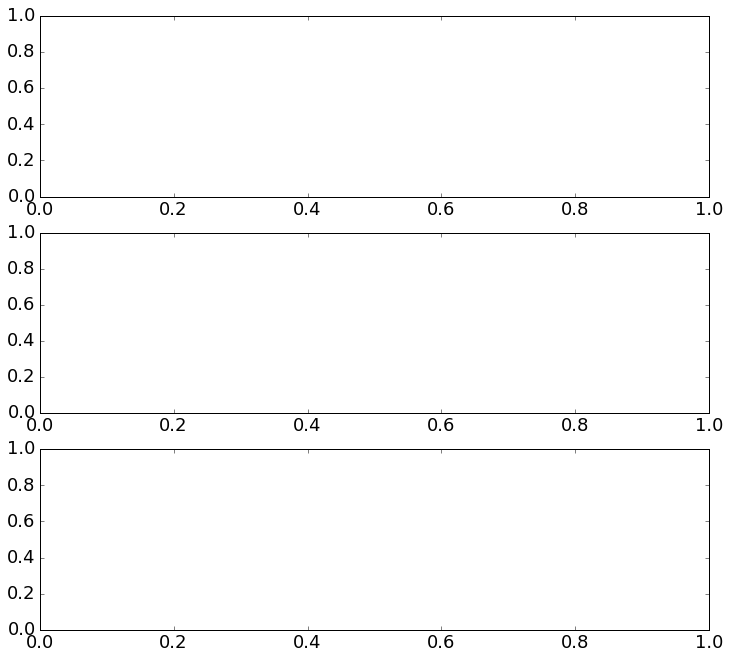

In [7]:
fig1, ax1 = plt.subplots(3,1)
plt.sca(ax1[0,0])
ax1[0,0].set_title('Average evaluation error during exploration')
plt.hold(True)
plt.errorbar(range(13),error_ev_av['proprio_social'],std_ev['proprio_social'],linestyle='None', marker='o', color='b')
plt.errorbar(range(13),error_ev_av['proprio_autonomous'],std_ev['proprio_autonomous'], linestyle='-', marker='o', color='r')
plt.errorbar(range(13),error_ev_av['simple_social'],std_ev['simple_social'], linestyle='-', marker='o', color='g')
plt.errorbar(range(13),error_ev_av['simple_autonomous'],std_ev['simple_autonomous'], linestyle='-', marker='o', color='k')
plt.xlabel('Evaluation step [k]')
plt.ylabel('Average evaluation error')
plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'],\
           ncol=2,loc='lower right', fontsize=15)
ax1[0,0].set_ylim([1.3,2.1])

In [ ]:
std_ev